# Record3D Point Cloud Visualization

This notebook visualizes combined point clouds from all cameras to check alignment.


In [5]:
!cd /workspace/Home_Reconstruction
!chmod +x setup.sh
!./setup.sh

chmod: cannot access 'setup.sh': No such file or directory
/bin/bash: line 1: ./setup.sh: No such file or directory


In [2]:
import sys
import os
from pathlib import Path
import numpy as np
import torch

path = os.getcwd() + "workspace/Home_Reconstruction/scene/"
sys.path.append(path)
from data_loaders.record3d_loader import Record3DScene

# For notebook visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


ModuleNotFoundError: No module named 'scipy._lib'

In [20]:
def create_point_cloud_from_rgbd(cam, subsample=4):
    """
    Create a point cloud from RGB-D camera data
    
    Args:
        cam: Record3DCamera object
        subsample: Subsample factor to reduce point count (use every Nth pixel)
    
    Returns:
        points: Nx3 numpy array of 3D points in world coordinates
        colors: Nx3 numpy array of RGB colors [0, 1]
    """
    if cam.depth_map is None:
        return None, None
    
    # Get image dimensions
    H, W = cam.depth_map.shape
    
    # Create pixel grid (subsampled)
    u = torch.arange(0, W, subsample, dtype=torch.float32)
    v = torch.arange(0, H, subsample, dtype=torch.float32)
    u_grid, v_grid = torch.meshgrid(u, v, indexing='xy')
    u_flat = u_grid.flatten()
    v_flat = v_grid.flatten()
    
    # Get depth values at these pixels
    depth_flat = cam.depth_map[v_flat.long(), u_flat.long()]
    
    # Filter out invalid depth (zero or NaN)
    valid = (depth_flat > 0) & torch.isfinite(depth_flat)
    u_valid = u_flat[valid]
    v_valid = v_flat[valid]
    depth_valid = depth_flat[valid]
    
    if len(depth_valid) == 0:
        return None, None
    
    # Convert to camera coordinates using intrinsics
    # Standard pinhole camera model: x = (u - cx) * z / fx, y = (v - cy) * z / fy, z = depth
    # Record3D uses ARKit convention: +Z backward, +Y up
    # The c2w matrix handles the coordinate system transformation
    fx, fy = cam.fx, cam.fy
    cx, cy = cam.cx, cam.cy
    
    # Unproject depth to 3D camera coordinates
    x_cam = (u_valid - cx) * depth_valid / fx
    y_cam = -(v_valid - cy) * depth_valid / fy
    z_cam = -depth_valid
    
    # Stack into [N, 3] tensor
    points_cam = torch.stack([x_cam, y_cam, z_cam], dim=1)
    
    # Transform to world coordinates using c2w matrix
    # Record3D stores c2w (camera-to-world) matrices in row-major order
    # The c2w matrix transforms points from camera space to world space
    
    # Add homogeneous coordinate
    ones = torch.ones(len(points_cam), 1)
    points_cam_hom = torch.cat([points_cam, ones], dim=1)  # [N, 4]
    
    # Transform using row-vector convention: P_world = P_cam @ c2w^T
    # Equivalent to: (c2w @ P_cam^T)^T but more efficient for row vectors
    points_world_hom = points_cam_hom @ cam.c2w.T  # [N, 4] @ [4, 4] -> [N, 4]
    points_world = points_world_hom[:, :3]  # Extract xyz, drop homogeneous coordinate
    
    # Get RGB colors at valid pixels
    # original_image is [3, H, W]
    rgb_flat = cam.original_image[:, v_valid.long(), u_valid.long()].T  # [N, 3]
    
    return points_world.numpy(), rgb_flat.numpy()


## Load Scene


In [60]:
# Load scene
scene_path = Path("/workspace/Home_Reconstruction/data_scenes/maria_bedroom")

scene = Record3DScene(
    scene_path=scene_path,
    train_frames= list(range(100)),
    test_frames=[0],
    gaussians=None,
    voxel_size=0.005
)

print(f"Loaded scene:")
print(f"  Training cameras: {len(scene.train_cameras)}")
print(f"  Test cameras: {len(scene.test_cameras)}")


Loaded metadata from /workspace/Home_Reconstruction/data_scenes/maria_bedroom/EXR_RGBD/metadata.json
  Image dimensions: 720x960
  Number of frames: 9720

Dataset split:
  Training: 100 frames
  Testing: 1 frames

Creating 100 cameras...
Created 100 cameras

Creating 1 cameras...
Created 1 cameras
Loaded scene:
  Training cameras: 100
  Test cameras: 1


## Create Combined Point Cloud


In [61]:
# Generate point clouds per frame (DON'T combine yet!)
points_by_frame = []
colors_by_frame = []
camera_positions = []

# Process training cameras
print(f"Processing {len(scene.train_cameras)} training cameras...")
for i, cam in enumerate(scene.train_cameras):
    points, colors = create_point_cloud_from_rgbd(cam, subsample=4)
    if points is not None and len(points) > 0:
        points_by_frame.append(points)  # Keep separate
        colors_by_frame.append(colors)  # Keep separate
        camera_positions.append(cam.camera_center.numpy())
        #print(f"  Camera {i}: {len(points):,} points")

# Process test cameras
print(f"\nProcessing {len(scene.test_cameras)} test cameras...")
for i, cam in enumerate(scene.test_cameras):
    points, colors = create_point_cloud_from_rgbd(cam, subsample=4)
    if points is not None and len(points) > 0:
        points_by_frame.append(points)  # Keep separate
        colors_by_frame.append(colors)  # Keep separate
        camera_positions.append(cam.camera_center.numpy())
        #print(f"  Test camera {i}: {len(points):,} points")

camera_positions = np.array(camera_positions)

print(f"\nGenerated {len(points_by_frame)} point clouds")
print(f"Total points: {sum(len(p) for p in points_by_frame):,}")


Processing 100 training cameras...

Processing 1 test cameras...

Generated 101 point clouds
Total points: 4,172,687


## Visualize with Matplotlib (Interactive 3D)


Downsampling from 24087116 to 50k points for visualization...


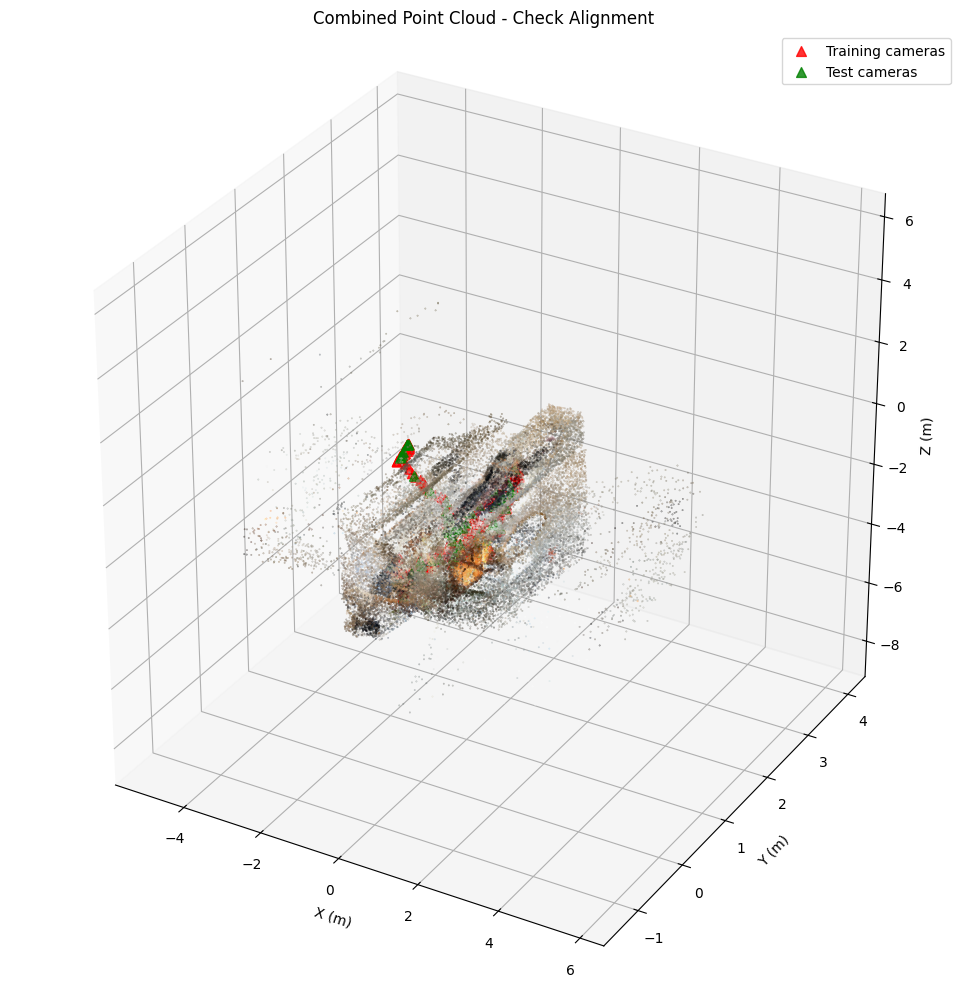

In [31]:
# Downsample for faster visualization
if len(combined_points) > 50000:
    print(f"Downsampling from {len(combined_points)} to 50k points for visualization...")
    indices = np.random.choice(len(combined_points), 50000, replace=False)
    vis_points = combined_points[indices]
    vis_colors = combined_colors[indices]
else:
    vis_points = combined_points
    vis_colors = combined_colors

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot point cloud
ax.scatter(vis_points[:, 0], vis_points[:, 1], vis_points[:, 2], 
           c=vis_colors, s=0.1, alpha=0.6)

# Plot camera positions
train_positions = np.array([pos for label, pos in camera_positions if label == 'train'])
test_positions = np.array([pos for label, pos in camera_positions if label == 'test'])

if len(train_positions) > 0:
    ax.scatter(train_positions[:, 0], train_positions[:, 1], train_positions[:, 2],
               c='red', s=50, marker='^', label='Training cameras', alpha=0.8)
if len(test_positions) > 0:
    ax.scatter(test_positions[:, 0], test_positions[:, 1], test_positions[:, 2],
               c='green', s=50, marker='^', label='Test cameras', alpha=0.8)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Combined Point Cloud - Check Alignment')
ax.legend()
ax.set_box_aspect([1,1,1])  # Equal aspect ratio

plt.tight_layout()
plt.show()


## Alternative: Plotly Interactive Visualization

For better interactivity in notebooks, you can use Plotly (requires: `pip install plotly`)


In [11]:
!pip install scikit-learn
!pip install plotly

  Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [52]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.stats import zscore

def clean_point_cloud_multiview(points_by_frame, colors_by_frame, 
                                min_views=2, distance_threshold=0.10,
                                voxel_size=0.02, std_multiplier=1.5, min_neighbors=8):
    """
    Clean point cloud with multi-view consistency AT THE END (fast!)
    
    Args:
        points_by_frame: List of [N, 3] numpy arrays (one per camera frame)
        colors_by_frame: List of [N, 3] numpy arrays (colors per frame)
        min_views: Minimum number of views a point must appear in (default: 2)
        distance_threshold: Max distance to consider points the same (default: 0.10m)
        voxel_size: Voxel size for downsampling (meters). Default 0.02 (2cm)
        std_multiplier: Outlier threshold. Lower = more aggressive. Default 1.5
        min_neighbors: Min neighbors in radius. Higher = remove more. Default 8
    
    Returns:
        cleaned_points: [M, 3] numpy array
        cleaned_colors: [M, 3] numpy array
    """
    
    # Combine all points WITH frame IDs
    all_points = []
    all_colors = []
    all_frame_ids = []
    
    for frame_idx, (pts, cols) in enumerate(zip(points_by_frame, colors_by_frame)):
        all_points.append(pts)
        all_colors.append(cols)
        all_frame_ids.append(np.full(len(pts), frame_idx))  # Track which frame
    
    points = np.vstack(all_points)
    colors = np.vstack(all_colors)
    frame_ids = np.concatenate(all_frame_ids)  # Keep frame IDs!
    
    print(f"Input: {len(points):,} points from {len(points_by_frame)} frames\n")
    
    # 1. Voxel downsampling (KEEP FRAME IDs)
    print("[1/4] Voxel downsampling...")
    voxel_indices = np.floor(points / voxel_size).astype(int)
    unique_voxels = {}
    
    for i in range(len(points)):
        key = tuple(voxel_indices[i])
        if key not in unique_voxels:
            unique_voxels[key] = i
    
    keep_indices = list(unique_voxels.values())
    points = points[keep_indices]
    colors = colors[keep_indices]
    frame_ids = frame_ids[keep_indices]  # ← Keep frame IDs through pipeline!
    print(f"      → {len(points):,} points\n")
    
    # 2. Statistical outlier removal (KEEP FRAME IDs)
    print("[2/4] Statistical outlier removal...")
    tree = cKDTree(points)
    k = min(31, len(points))
    distances, _ = tree.query(points, k=k)
    mean_distances = distances[:, 1:].mean(axis=1)
    
    z_scores = np.abs(zscore(mean_distances))
    outlier_mask = z_scores < std_multiplier
    
    points = points[outlier_mask]
    colors = colors[outlier_mask]
    frame_ids = frame_ids[outlier_mask]  # ← Keep frame IDs!
    print(f"      → {len(points):,} points\n")
    
    # 3. Radius filtering (KEEP FRAME IDs)
    print("[3/4] Radius filtering...")
    tree = cKDTree(points)
    neighbor_counts = np.array([len(tree.query_ball_point(p, r=voxel_size*3)) for p in points])
    radius_mask = neighbor_counts >= min_neighbors
    
    points = points[radius_mask]
    colors = colors[radius_mask]
    frame_ids = frame_ids[radius_mask]  # ← Keep frame IDs!
    print(f"      → {len(points):,} points\n")
    
    # 4. Multi-view consistency (NOW - much faster!)
    print(f"[4/4] Multi-view consistency filtering...")
    print(f"      Distance threshold: {distance_threshold}m, min views: {min_views}")
    print(f"      Checking {len(points):,} points (fast!)")
    
    tree = cKDTree(points)
    keep_mask = np.zeros(len(points), dtype=bool)
    
    for i in range(len(points)):
        if i % 50000 == 0 and i > 0:
            print(f"      Progress: {i:,}/{len(points):,} ({100*i/len(points):.1f}%)")
        
        # Find nearby points
        neighbors = tree.query_ball_point(points[i], r=distance_threshold)
        
        # Count unique frames using the frame_ids we kept!
        unique_frames = len(set(frame_ids[neighbors]))
        
        # Keep if seen from multiple views
        if unique_frames >= min_views:
            keep_mask[i] = True
    
    points = points[keep_mask]
    colors = colors[keep_mask]
    print(f"      → {len(points):,} points ({100*keep_mask.sum()/len(keep_mask):.1f}% kept)\n")
    
    print(f"Final: {len(points):,} points\n")
    
    return points, colors

# Clean with multi-view consistency (AT THE END - fast!)
cleaned_points, cleaned_colors = clean_point_cloud_multiview(
    points_by_frame,       # List of arrays, not combined!
    colors_by_frame,       # List of arrays, not combined!
    min_views=10,           # Must appear in 2+ views
    distance_threshold=0.10,  # 10cm tolerance (increased from 3cm)
    voxel_size=0.02,       # 2cm voxels
    std_multiplier=1.5,    # Standard filtering
    min_neighbors=8        # Radius filtering
)

Input: 24,087,438 points from 583 frames

[1/4] Voxel downsampling...
      → 1,549,379 points

[2/4] Statistical outlier removal...
      → 1,462,687 points

[3/4] Radius filtering...
      → 1,457,033 points

[4/4] Multi-view consistency filtering...
      Distance threshold: 0.1m, min views: 10
      Checking 1,457,033 points (fast!)
      Progress: 50,000/1,457,033 (3.4%)
      Progress: 100,000/1,457,033 (6.9%)
      Progress: 150,000/1,457,033 (10.3%)
      Progress: 200,000/1,457,033 (13.7%)
      Progress: 250,000/1,457,033 (17.2%)
      Progress: 300,000/1,457,033 (20.6%)
      Progress: 350,000/1,457,033 (24.0%)
      Progress: 400,000/1,457,033 (27.5%)
      Progress: 450,000/1,457,033 (30.9%)
      Progress: 500,000/1,457,033 (34.3%)
      Progress: 550,000/1,457,033 (37.7%)
      Progress: 600,000/1,457,033 (41.2%)
      Progress: 650,000/1,457,033 (44.6%)
      Progress: 700,000/1,457,033 (48.0%)
      Progress: 750,000/1,457,033 (51.5%)
      Progress: 800,000/1,457,033 

In [58]:
# After your current cleaning, add DBSCAN as final step
from sklearn.cluster import DBSCAN

print("Final DBSCAN cleanup...")
clustering = DBSCAN(eps=0.30, min_samples=500, n_jobs=-1)
labels = clustering.fit_predict(cleaned_points)

# Keep only largest cluster
unique, counts = np.unique(labels[labels != -1], return_counts=True)
largest = unique[np.argmax(counts)]

mask = labels == largest
new_cleaned_points = cleaned_points[mask]
new_cleaned_colors = cleaned_colors[mask]

print(f"After DBSCAN: {len(new_cleaned_points):,} points")

Final DBSCAN cleanup...
After DBSCAN: 1,047,504 points


In [64]:
def multiview_filter(points_by_frame, colors_by_frame, min_views=2, distance_threshold=0.10, voxel_size=0.02):
    """
    Voxel downsample + keep only points that appear in multiple views
    
    Args:
        points_by_frame: List of [N, 3] numpy arrays (one per frame)
        colors_by_frame: List of [N, 3] numpy arrays (colors per frame)
        min_views: Minimum number of views a point must appear in
        distance_threshold: Max distance (m) to consider points the same
        voxel_size: Voxel size for downsampling (meters), default 0.02 (2cm)
    
    Returns:
        filtered_points: [M, 3] numpy array
        filtered_colors: [M, 3] numpy array
    """
    from scipy.spatial import cKDTree
    
    # Combine with frame IDs
    all_points = []
    all_colors = []
    frame_ids = []
    
    for frame_idx, (pts, cols) in enumerate(zip(points_by_frame, colors_by_frame)):
        all_points.append(pts)
        all_colors.append(cols)
        frame_ids.extend([frame_idx] * len(pts))
    
    points = np.vstack(all_points)
    colors = np.vstack(all_colors)
    frame_ids = np.array(frame_ids)
    
    print(f"Input: {len(points):,} points, {len(points_by_frame)} frames")
    
    # Voxel downsampling (keep frame IDs)
    print(f"Voxel downsampling ({voxel_size}m)...")
    voxel_indices = np.floor(points / voxel_size).astype(int)
    unique_voxels = {}
    
    for i in range(len(points)):
        key = tuple(voxel_indices[i])
        if key not in unique_voxels:
            unique_voxels[key] = i
    
    keep_indices = list(unique_voxels.values())
    points = points[keep_indices]
    colors = colors[keep_indices]
    frame_ids = frame_ids[keep_indices]
    print(f"  → {len(points):,} points\n")
    
    # Multi-view filtering
    print(f"Multi-view filter (min_views={min_views}, threshold={distance_threshold}m)...")
    tree = cKDTree(points)
    keep_mask = np.zeros(len(points), dtype=bool)
    
    for i in range(len(points)):
        if i % 50000 == 0 and i > 0:
            print(f"  Progress: {i:,}/{len(points):,}")
        
        neighbors = tree.query_ball_point(points[i], r=distance_threshold)
        unique_frames = len(set(frame_ids[neighbors]))
        
        if unique_frames >= min_views:
            keep_mask[i] = True
    
    filtered_points = points[keep_mask]
    filtered_colors = colors[keep_mask]
    
    print(f"  → Kept {len(filtered_points):,} ({100*keep_mask.sum()/len(points):.1f}%)\n")
    
    return filtered_points, filtered_colors

# Usage:
filtered_points, filtered_colors = multiview_filter(
    combined_points, 
    combined_colors, 
    min_views=2, 
    distance_threshold=0.10,
    voxel_size=0.02  # 2cm voxels
)

Input: 24,087,438 points, 24087438 frames
Voxel downsampling (0.02m)...
  → 1,549,379 points

Multi-view filter (min_views=2, threshold=0.1m)...
  Progress: 50,000/1,549,379
  Progress: 100,000/1,549,379
  Progress: 150,000/1,549,379
  Progress: 200,000/1,549,379
  Progress: 250,000/1,549,379
  Progress: 300,000/1,549,379
  Progress: 350,000/1,549,379
  Progress: 400,000/1,549,379
  Progress: 450,000/1,549,379
  Progress: 500,000/1,549,379
  Progress: 550,000/1,549,379
  Progress: 600,000/1,549,379
  Progress: 650,000/1,549,379
  Progress: 700,000/1,549,379
  Progress: 750,000/1,549,379
  Progress: 800,000/1,549,379
  Progress: 850,000/1,549,379
  Progress: 900,000/1,549,379
  Progress: 950,000/1,549,379
  Progress: 1,000,000/1,549,379
  Progress: 1,050,000/1,549,379
  Progress: 1,100,000/1,549,379
  Progress: 1,150,000/1,549,379
  Progress: 1,200,000/1,549,379
  Progress: 1,250,000/1,549,379
  Progress: 1,300,000/1,549,379
  Progress: 1,350,000/1,549,379
  Progress: 1,400,000/1,549,37

In [65]:
# Uncomment to use Plotly (requires: pip install plotly)
try:
    import plotly.graph_objects as go
    import plotly.io as pio
    pio.renderers.default = "notebook_connected"

    


    use_filtered = False
    if use_filtered:
        disp_points = new_cleaned_points
        disp_colors = new_cleaned_colors
    else:
        disp_points = filtered_points
        disp_colors = filtered_colors
    
    # Downsample for plotly
    if len(disp_points) > 100000:
        indices = np.random.choice(len(disp_points), 100000, replace=False)
        plot_points = disp_points[indices]
        plot_colors = disp_colors[indices]
    else:
        plot_points = disp_points
        plot_colors = disp_colors
    
    # Create scatter plot
    fig = go.Figure(data=go.Scatter3d(
        x=plot_points[:, 0],
        y=plot_points[:, 1],
        z=plot_points[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=plot_colors,
            opacity=0.6
        )
    ))

    train_positions = np.array([cam.camera_center.cpu().numpy() for cam in scene.train_cameras])
    test_positions = np.array([cam.camera_center.cpu().numpy() for cam in scene.test_cameras])

    colors_rgb = (plot_colors * 255).astype(int)
    color_strings = [f'rgb({r},{g},{b})' for r, g, b in colors_rgb]




    # # Add camera positions
    # if len(train_positions) > 0:
        
    #     fig.add_trace(go.Scatter3d(
    #         x=train_positions[:, 0],
    #         y=train_positions[:, 1],
    #         z=train_positions[:, 2],
    #         mode='markers',
    #         marker=dict(size=10, color='red', symbol='diamond'),
    #         name='Training cameras'
    #     ))

    

    
    # if len(test_positions) > 0:
    #     fig.add_trace(go.Scatter3d(
    #         x=test_positions[:, 0],
    #         y=test_positions[:, 1],
    #         z=test_positions[:, 2],
    #         mode='markers',
    #         marker=dict(size=10, color='green', symbol='diamond'),
    #         name='Test cameras'
    #     ))
    
    fig.update_layout(
        title='Combined Point Cloud - Check Alignment',
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data'
        ),
        width=1000,
        height=800
    )
    
    
    fig.show()
except ImportError:
    print("Plotly not installed. Install with: pip install plotly")


In [22]:
import numpy as np
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("="*80)
print("COMPREHENSIVE POINT CLOUD MERGE DIAGNOSTICS")
print("="*80)

# Use frames with actual movement
test_frames = [0, 100, 200, 300, 400]

# Load scene
scene_path = Path("/workspace/Home_Reconstruction/data_scenes/maria_bedroom")
scene = Record3DScene(
    scene_path=scene_path,
    train_frames=test_frames,
    test_frames=[],
    gaussians=None,
    voxel_size=0.005
)

# ============================================================================
# TEST 1: Camera Pose Validation
# ============================================================================
print("\n" + "="*80)
print("TEST 1: CAMERA POSE VALIDATION")
print("="*80)

for i, cam in enumerate(scene.train_cameras):
    c2w = cam.c2w.float()  # Ensure float32
    R = c2w[:3, :3]
    t = c2w[:3, 3]
    
    # Check rotation matrix properties
    det = torch.det(R)
    orthogonal = torch.allclose(R @ R.T, torch.eye(3), atol=1e-3)
    
    print(f"\nFrame {test_frames[i]}:")
    print(f"  Position: {t.numpy()}")
    print(f"  Rotation det: {det:.6f} (should be 1.0)")
    print(f"  Is orthogonal: {orthogonal}")
    
    # Check for reflection (det should be +1, not -1)
    if det < 0:
        print(f"  ⚠️  WARNING: Negative determinant - this is a REFLECTION!")

# ============================================================================
# TEST 2: Point Cloud Center vs Camera Position
# ============================================================================
print("\n" + "="*80)
print("TEST 2: POINT CLOUD CENTERS VS CAMERA POSITIONS")
print("="*80)

pc_centers = []
cam_positions = []

for i, cam in enumerate(scene.train_cameras):
    points, colors = create_point_cloud_from_rgbd(cam, subsample=4)
    
    if points is not None:
        pc_center = points.mean(axis=0)
        cam_pos = cam.camera_center.numpy()
        
        pc_centers.append(pc_center)
        cam_positions.append(cam_pos)
        
        dist_to_pc = np.linalg.norm(cam_pos - pc_center)
        
        print(f"\nFrame {test_frames[i]}:")
        print(f"  Camera position:     {cam_pos}")
        print(f"  Point cloud center:  {pc_center}")
        print(f"  Distance:            {dist_to_pc:.3f}m")
        
        # Camera should be ~1-3m from scene center
        if dist_to_pc < 0.5 or dist_to_pc > 5:
            print(f"  ⚠️  WARNING: Unusual distance!")

pc_centers = np.array(pc_centers)
cam_positions = np.array(cam_positions)

# Check if point cloud centers track with camera movement
pc_movement = np.linalg.norm(pc_centers[-1] - pc_centers[0])
cam_movement = np.linalg.norm(cam_positions[-1] - cam_positions[0])

print(f"\nOverall movement:")
print(f"  Camera moved:        {cam_movement:.3f}m")
print(f"  PC centers moved:    {pc_movement:.3f}m")

if cam_movement > 0.01:  # Only check if camera actually moved
    ratio = abs(pc_movement - cam_movement) / cam_movement
    if ratio > 0.5:
        print(f"  ⚠️  WARNING: Point cloud centers move differently than cameras!")
        print(f"  This suggests points might still be in camera space!")

# ============================================================================
# TEST 3: Pairwise Point Cloud Alignment
# ============================================================================
print("\n" + "="*80)
print("TEST 3: PAIRWISE ALIGNMENT CHECK")
print("="*80)

all_pcs = []
for i, cam in enumerate(scene.train_cameras):
    points, colors = create_point_cloud_from_rgbd(cam, subsample=8)
    if points is not None:
        all_pcs.append(points)

# For each pair of consecutive frames, check alignment
for i in range(len(all_pcs) - 1):
    pc1 = all_pcs[i]
    pc2 = all_pcs[i + 1]
    
    # Find nearest neighbors between point clouds
    from scipy.spatial import cKDTree
    tree = cKDTree(pc2)
    distances, _ = tree.query(pc1[::10])  # Subsample for speed
    
    mean_dist = distances.mean()
    median_dist = np.median(distances)
    
    print(f"\nFrame {test_frames[i]} → {test_frames[i+1]}:")
    print(f"  Mean nearest-neighbor distance:   {mean_dist:.4f}m")
    print(f"  Median nearest-neighbor distance: {median_dist:.4f}m")
    
    # Good alignment: distances should be < 2cm for overlapping regions
    if median_dist > 0.05:
        print(f"  ⚠️  WARNING: Large alignment error!")

# ============================================================================
# TEST 4: Test Forward/Backward Transformation
# ============================================================================
print("\n" + "="*80)
print("TEST 4: ROUND-TRIP TRANSFORMATION TEST")
print("="*80)

cam = scene.train_cameras[0]

# Take a point in world space
test_point_world = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32)

# Transform to camera space
w2c = torch.inverse(cam.c2w.float())
test_point_cam_hom = w2c @ torch.cat([test_point_world, torch.tensor([1.0], dtype=torch.float32)])
test_point_cam = test_point_cam_hom[:3]

# Transform back to world space
test_point_world_reconstructed_hom = cam.c2w.float() @ torch.cat([test_point_cam, torch.tensor([1.0], dtype=torch.float32)])
test_point_world_reconstructed = test_point_world_reconstructed_hom[:3]

error = torch.norm(test_point_world - test_point_world_reconstructed)

print(f"Original world point:      {test_point_world.numpy()}")
print(f"After cam→world→cam:       {test_point_world_reconstructed.numpy()}")
print(f"Round-trip error:          {error:.9f}m")

if error > 1e-5:
    print(f"⚠️  WARNING: Round-trip transformation has error!")

# ============================================================================
# TEST 5: Check Coordinate System Handedness
# ============================================================================
print("\n" + "="*80)
print("TEST 5: COORDINATE SYSTEM HANDEDNESS")
print("="*80)

# Sample points at different depths from first camera
cam = scene.train_cameras[0]
H, W = cam.depth_map.shape

# Take 3 points forming a triangle in the image
points_2d = [
    (W//2, H//2),      # Center
    (W//2 + 50, H//2), # Right
    (W//2, H//2 + 50), # Down
]

points_cam_list = []
points_world_list = []

for u, v in points_2d:
    depth = cam.depth_map[v, u].item()
    if depth > 0:
        # Unproject to camera space
        x_cam = (u - cam.cx) * depth / cam.fx
        y_cam = (v - cam.cy) * depth / cam.fy
        z_cam = depth
        
        points_cam_list.append([x_cam, y_cam, z_cam])
        
        # Transform to world (ensure float32)
        p_cam_hom = torch.tensor([[x_cam, y_cam, z_cam, 1.0]], dtype=torch.float32)
        p_world = p_cam_hom @ cam.c2w.float().T
        points_world_list.append(p_world[0, :3].numpy())

if len(points_cam_list) == 3:
    # Compute cross product in camera space
    v1_cam = np.array(points_cam_list[1]) - np.array(points_cam_list[0])
    v2_cam = np.array(points_cam_list[2]) - np.array(points_cam_list[0])
    normal_cam = np.cross(v1_cam, v2_cam)
    
    # Compute cross product in world space
    v1_world = points_world_list[1] - points_world_list[0]
    v2_world = points_world_list[2] - points_world_list[0]
    normal_world = np.cross(v1_world, v2_world)
    
    print(f"Triangle normal in camera space: {normal_cam / np.linalg.norm(normal_cam)}")
    print(f"Triangle normal in world space:  {normal_world / np.linalg.norm(normal_world)}")
    
    # Transform camera normal to world using rotation matrix
    R = cam.c2w.float()[:3, :3].numpy()
    normal_cam_to_world = R @ normal_cam
    normal_cam_to_world = normal_cam_to_world / np.linalg.norm(normal_cam_to_world)
    
    print(f"Camera normal transformed:       {normal_cam_to_world}")
    
    # They should match
    diff = np.linalg.norm(normal_world / np.linalg.norm(normal_world) - normal_cam_to_world)
    print(f"Difference: {diff:.6f}")
    
    if diff > 0.01:
        print(f"⚠️  WARNING: Normals don't match - coordinate system issue!")

# ============================================================================
# TEST 6: Visualize Transformation Step-by-Step
# ============================================================================
print("\n" + "="*80)
print("TEST 6: STEP-BY-STEP TRANSFORMATION VISUALIZATION")
print("="*80)

# Take ONE depth map and show transformation at each step
cam = scene.train_cameras[0]
H, W = cam.depth_map.shape

# Sample some pixels
sample_pixels = [
    (W//2, H//2),           # Center
    (W//4, H//4),           # Top-left
    (3*W//4, 3*H//4),       # Bottom-right
]

print("\nSample transformations:")
for u, v in sample_pixels:
    depth = cam.depth_map[v, u].item()
    if depth > 0:
        print(f"\nPixel ({u}, {v}):")
        print(f"  Depth: {depth:.3f}m")
        
        # Step 1: Unproject
        x_cam = (u - cam.cx) * depth / cam.fx
        y_cam = (v - cam.cy) * depth / cam.fy
        z_cam = depth
        print(f"  Camera space: [{x_cam:.3f}, {y_cam:.3f}, {z_cam:.3f}]")
        
        # Step 2: Transform to world
        p_cam = torch.tensor([x_cam, y_cam, z_cam], dtype=torch.float32)
        R = cam.c2w.float()[:3, :3]
        t = cam.c2w.float()[:3, 3]
        p_world = R @ p_cam + t
        print(f"  World space:  {p_world.numpy()}")
        
        # Step 3: Distance from camera
        dist = torch.norm(p_world - cam.camera_center.float())
        print(f"  Distance from camera: {dist:.3f}m (should be ~{depth:.3f}m)")
        
        if abs(dist - depth) > 0.01:
            print(f"  ⚠️  WARNING: Distance mismatch!")

print("\n" + "="*80)
print("DIAGNOSTICS COMPLETE")
print("="*80)

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\nGenerating visualization...")

fig = go.Figure()
colors_list = ['red', 'green', 'blue', 'yellow', 'purple']

for i, cam in enumerate(scene.train_cameras):
    points, colors = create_point_cloud_from_rgbd(cam, subsample=8)
    
    if points is not None:
        # Subsample for viz
        n_show = 5000
        idx = np.random.choice(len(points), min(n_show, len(points)), replace=False)
        
        fig.add_trace(go.Scatter3d(
            x=points[idx, 0],
            y=points[idx, 1],
            z=points[idx, 2],
            mode='markers',
            marker=dict(size=2, color=colors_list[i], opacity=0.5),
            name=f'Frame {test_frames[i]}'
        ))
        
        # Add camera position
        cam_pos = cam.camera_center.numpy()
        fig.add_trace(go.Scatter3d(
            x=[cam_pos[0]],
            y=[cam_pos[1]],
            z=[cam_pos[2]],
            mode='markers',
            marker=dict(size=15, color=colors_list[i], symbol='diamond'),
            name=f'Camera {test_frames[i]}',
            showlegend=True
        ))

fig.update_layout(
    title='All Point Clouds (each color = different frame - should overlap)',
    scene=dict(aspectmode='data'),
    width=1400, height=1000
)

fig.write_html("diagnostic_merge.html")
print("\n✓ Saved to diagnostic_merge.html")
fig.show()

COMPREHENSIVE POINT CLOUD MERGE DIAGNOSTICS
Loaded metadata from /workspace/Home_Reconstruction/data_scenes/maria_bedroom/EXR_RGBD/metadata.json
  Image dimensions: 720x960
  Number of frames: 9720

Dataset split:
  Training: 5 frames
  Testing: 0 frames

Creating 5 cameras...
Created 5 cameras

Creating 0 cameras...
Created 0 cameras

TEST 1: CAMERA POSE VALIDATION

Frame 0:
  Position: [-0.7099652   0.14966764  0.85502696]
  Rotation det: 1.000000 (should be 1.0)
  Is orthogonal: True

Frame 100:
  Position: [-0.72536033  0.2443337   0.8820298 ]
  Rotation det: 1.000000 (should be 1.0)
  Is orthogonal: True

Frame 200:
  Position: [-0.7969596   0.39644688  0.9461663 ]
  Rotation det: 1.000000 (should be 1.0)
  Is orthogonal: True

Frame 300:
  Position: [-0.80433786  0.44944948  0.9733106 ]
  Rotation det: 1.000000 (should be 1.0)
  Is orthogonal: True

Frame 400:
  Position: [-0.7309598  0.4229155  0.9792236]
  Rotation det: 1.000000 (should be 1.0)
  Is orthogonal: True

TEST 2: PO